In [124]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib import cm, ticker, transforms
import matplotlib.colors as mcolors
from types import DynamicClassAttribute
import math
import matplotlib.patches as patches
#import sympy as sp
from itertools import combinations_with_replacement, product
#from scipy import linalg
from matplotlib import cm
from matplotlib.ticker import LinearLocator

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

Unknown-model barrier

In [125]:
# Dynamical system x(t+1) = 0.5x(t)

## start:Define functions

def fdt(x):
    x = np.array(x)
    tau = 0.01
    x[0] = x[0]+ tau*(-2*x[0] + 2*x[1])
    x[1] = x[1] + tau*(-2*x[1] + x[0])
    return x

def dynsys(x0,T=1):
    x0 = np.array(x0)
    x = []
    for j in range(T):
      x.append(x0)
      x0 = x[-1]
      x0 = fdt(x0)
    return x
## end:Define functions


In [126]:
# Define the functions

def fcTi(z, tr):
    tr = np.array(tr)  # Ensure x is a NumPy array
    indices = np.where(z <= tr)[0]  # Get indices where z <= x[i]
    if len(indices) == 0:
        return 1.1
    else:
        return 1/(1+np.max(indices))  # Return the largest index

def fcT(X,Y):
    X = np.array(X)
    Y = np.array(Y)
    #t = np.maximum(X[np.newaxis, :], Y[:, np.newaxis]
    return np.maximum(X,Y)

def fcTiX(X, trajectory):
    trajectory = np.array(trajectory)  # Ensure trajectory is a NumPy array
    indices = np.where(X[..., np.newaxis] <= trajectory, np.arange(trajectory.shape[-1]), -1)
    max_indices = np.max(indices, axis=-1)
    return  1/(1+max_indices)

def fcTX(XT1, XT2):
    return np.maximum(XT1, XT2)


In [127]:
# Dynamical system x(t+1) = 0.5x(t)
x0lb, x0ub = np.array([0,3]), np.array([2,5]) #Initial Set
xUlb2, xUub2 = np.array([6,6]), np.array([6,6]) #Unsafe Set
xUlb, xUub = np.array([4,0]), np.array([5,3]) #Unsafe Set
dim = 2
NSol = 3
granularity = 0.2
T = 1300
#x0 = np.array(np.round(np.random.uniform(1,7,(NSol,dim)),1))#(np.random.rand(NSol,dim)+1))
#x0 = np.array([2,4.4])#,[5.6,6.5],[-0.5,3.0],[6,0.5]])
#x0 = np.array([[6,0.5],[5.6,6.5],[1.5,5.4]])#,[5.2,4.5]])
x0 = np.array([[6,0.5],[5.6,6.5],[2.5,6.4]])
print("Initial conditions for trajectories: \n",x0)
trajectory = np.array([dynsys(initial_condition, T) for initial_condition in x0])
#trajectory = np.array([dynsys(x0,T)])
x = np.arange(0, 5 + granularity,granularity)
y = np.arange(0, 5 + granularity, granularity)

X1, X2 = np.meshgrid(x, y, indexing='ij')
X = np.stack([X1, X2], axis=-1) # Combine the two grids

fT = []

# Compute fTT using vectorized operations
fT = np.full((NSol,len(x), len(y)), 1.1, dtype=float)  # Initialize with 1.1(default if no k satisfies)

for k in range(NSol):
    for t in range(T):
        # Check where points <= trajectory[0, k, :] element-wise
        mask = np.all(X <= trajectory[k,t, :], axis=-1)
        fT[k,mask] = 1/(1+t)  # Update fTT with the current index k where the condition is satisfied
fT = np.array(fT)

print("Granularity of Barrier grid: ",granularity)
print("Check final value of trajectories:\n",np.array([trajectory[k][-1] for k in range(NSol)]))
print("X dimension",X.shape,"fT dimension", fT.shape,"trajectory dimension",trajectory.shape)



Initial conditions for trajectories: 
 [[6.  0.5]
 [5.6 6.5]
 [2.5 6.4]]
Granularity of Barrier grid:  0.2
Check final value of trajectories:
 [[0.00153129 0.00107958]
 [0.00340748 0.00240233]
 [0.00266823 0.00188115]]
X dimension (26, 26, 2) fT dimension (3, 26, 26) trajectory dimension (3, 1300, 2)


0


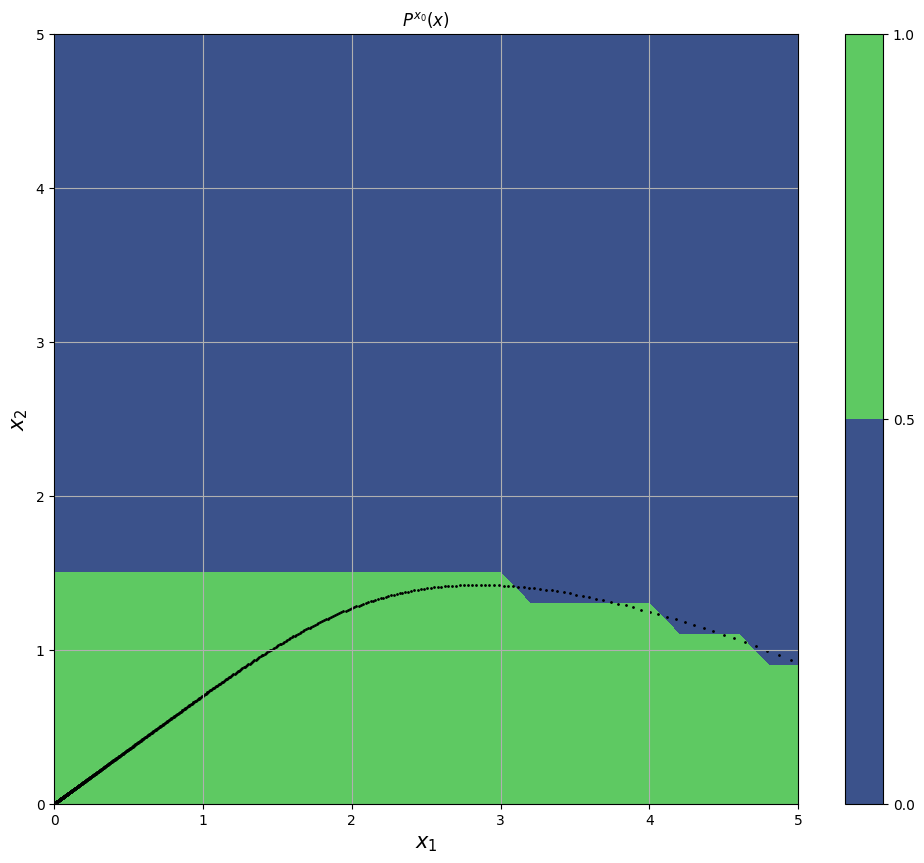

In [128]:
# # PLOT2: Dynamical system x(t+1) = 0.5x(t)
fig2,ax2= plt.subplots(figsize = (12,10))
#ax2 = fig2.add_subplot()

idx = np.random.randint(0,NSol)
print(idx)


# tr =24
cs = ax2.contourf(X1,X2,fT[idx]<=1)
#cs = ax2.pcolormesh(x,x,fT[idx])
ax2.scatter(trajectory[idx,:,0],trajectory[idx,:,1],s=1,c='black', marker='o', label='Trajectory')
fig2.colorbar(cs)

# Add labels, title, and legend
plt.xlabel('$x_1$',fontsize=15)
plt.ylabel('$x_2$',fontsize=15)
plt.title('$P^{x_0}(x)$')
plt.axis([0.0, 5, 0.0, 5])
plt.grid(True)



In [129]:
def PolY(vec, max_degree=1):
    vec = np.array(vec)  # Ensure input is a NumPy array
    n = len(vec)  # Number of variables
    
    # For max_degree=1, return [1, x1, x2, ...]
    if max_degree == 1:
        polyvec = np.concatenate([np.array([1.0]), vec], axis=0)
        polydvec = np.zeros((n, len(polyvec)))
        for i in range(n):
            polydvec[i, i+1] = 1.0  # derivative of x_i w.r.t x_i is 1
        return polyvec, polydvec
    
    # Generate all monomials up to max_degree, including the constant 1
    monomials = [1.0]  # Include the constant term
    for degree in range(1, max_degree + 1):
        for exponents in product(range(degree + 1), repeat=n):
            if sum(exponents) == degree:
                monomial = np.prod([vec[i]**exp for i, exp in enumerate(exponents)])
                monomials.append(monomial)
    
    # Convert monomials to polynomial vector
    polyvec = np.array(monomials, dtype=float)
    
    # Compute derivatives
    polydvec = np.zeros((n, len(monomials)))
    for i in range(n):
        for j, monomial in enumerate(monomials):
            derivative = 0.0
            for degree in range(1, max_degree + 1):
                for exponents in product(range(degree + 1), repeat=n):
                    if sum(exponents) == degree:
                        if exponents[i] > 0:
                            reduced_exponents = list(exponents)
                            reduced_exponents[i] -= 1
                            term = exponents[i] * np.prod([vec[k]**exp for k, exp in enumerate(reduced_exponents)])
                            if np.prod([vec[k]**exp for k, exp in enumerate(exponents)]) == monomial:
                                derivative += term
            polydvec[i, j] = derivative
    
    return polyvec, np.array(polydvec)

In [130]:
def BarT(t,c):
    return t@c

def dBarT(t,dt,ll):
    cc, tt = np.shape(dt)
    #ll = np.ones(tt)
    dd = []
    #print([i for i in range(tt)])
    for ii in range(cc):
        dd.append(ll[ii]*t + dt[ii,:])
    return np.array(dd)   

def dBarT2(dt,c):
    cc, tt = np.shape(dt)
    #ll = np.ones(tt)
    dd = []
    #print([i for i in range(tt)])
    for ii in range(tt):
        dd.append(dt[ii,:]@c)
    return dd  

In [131]:
# Find XU
# 2. Find indices inside the overapproximated unsafe region
maskU1 = (X[...,0] >= max(x[x <= xUlb[0]],default = 500)) & (X[..., 0] <= min(x[x >= xUub[0]],default = -500)) & \
       (X[..., 1] >= max(y[y <= xUlb[1]],default = 500)) & (X[..., 1] <= min(y[y >= xUub[1]],default = -500)) 

maskU2 = (X[..., 0] >= max(x[x <= xUlb2[0]],default = 500)) & (X[..., 0] <= min(x[x >= xUub2[0]],default = -500)) &\
       (X[..., 1] >= max(y[y <= xUlb2[1]],default = 500)) & (X[..., 1] <= min(y[y >= xUub2[1]],default = -500))

maskU = maskU1 | maskU2
indU1 = np.argwhere(maskU1)
indU2 = np.argwhere(maskU2)
indU = np.concatenate((indU1, indU2), axis=0)
# 3. Extract values in the intersection arrays
XU1 = X[maskU1]
XU2 = X[maskU2]
XU = np.concatenate((XU1, XU2), axis=0)
# 4. Find indices of the lowest and largest elements in each dimension
min_indU = np.min(indU, axis=0)
#max_indU = np.max(indU, axis=0)

# 5. Find the lowest and largest values in the intersection
min_XU = np.min(XU, axis=0)
#max_XU = np.max(XU, axis=0)

# Find XU
# 2. Find indices inside the overapproximated unsafe region
mask0 = (X[..., 0] >= np.max(x[x <= x0lb[0]])) & (X[..., 0] <= np.min(x[x >= x0ub[0]])) & \
       (X[..., 1] >= np.max(y[y <= x0lb[1]])) & (X[..., 1] <= np.min(y[y >= x0ub[1]]))
ind0 = np.argwhere(mask0)

# 3. Extract values in the intersection arrays
X0 = X[mask0]

# 4. Find indices of the lowest and largest elements in each dimension
#min_ind0 = np.min(ind0, axis=0)
max_ind0 = np.max(ind0, axis=0)

# 5. Find the lowest and largest values in the intersection
#min_X0 = np.min(X0, axis=0)
max_X0 = np.max(X0, axis=0)


# Find X_comp
# 2. Find indices inside the underapproximated unsafe region
maskUU1 = (X[..., 0] >= min(x[x >= xUlb[0]],default = -500)) & (X[..., 0] <= max(x[x <= xUub[0]],default = 500)) & \
       (X[..., 1] >= min(y[y >= xUlb[1]],default = -500)) & (X[..., 1] <= max(y[y <= xUub[1]],default = 500))
maskUU2 = (X[..., 0] >= min(x[x >= xUlb2[0]],default = -500)) & (X[..., 0] <= max(x[x <= xUub2[0]],default = 500)) & \
       (X[..., 1] >= min(y[y >= xUlb2[1]],default = -500)) & (X[..., 1] <= max(y[y <= xUub2[1]],default = 500))

maskUU = maskUU1 | maskUU2
indUU1 = np.argwhere(maskUU1)
indUU2 = np.argwhere(maskUU2)
indUU = np.concatenate((indUU1, indUU2), axis=0)


# 3. Extract values in the complement arrays
X_comp = X[~maskU]
ind_X_comp = np.argwhere(~maskU)

# Display results
# Display results
#print("Lowest indices in XU:", min_indU,", Lowest values in XU:", min_XU)
#print("Largest indices in X0:", max_ind0,", Largest values in X0:", max_X0)


print("Total elements in the grid ", X.shape[0]*X.shape[1])
print("Elements of Initial Set ", ind0.shape)
print("Elements of Unsafe Set ",indU.shape)
print("Elements of X\XU ",ind_X_comp.shape)

Total elements in the grid  676
Elements of Initial Set  (121, 2)
Elements of Unsafe Set  (96, 2)
Elements of X\XU  (580, 2)


In [132]:
PLOT = False
if PLOT == True:
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Black dots at ind_X_comp indices')

    # Plot black dots at every index in ind_X_comp
    for idx in ind_X_comp:
        xi, yi = idx
        ax.plot(x[xi], y[yi], 'ko', markersize=4)
    for idx in ind0:
        xi, yi = idx
        ax.plot(x[xi], y[yi], 'bo', markersize=4)
    for idx in indU:
        xi, yi = idx
        ax.plot(x[xi], y[yi], 'ro', markersize=4)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [133]:
consT = []

epsT = 0.001
maxdeg = 1
POS = True

vec,_ = PolY(fT[:,0,0],maxdeg)
lenPoly = len(vec)
#lenPoly = len(fTvec)
ll = 0.0*np.ones(lenPoly)
cTm = cp.Variable(lenPoly,nonneg=True,value = [1]*(lenPoly))
cTM = cp.Variable(lenPoly,nonneg=True,value = [1]*(lenPoly))
#consT.append(cT[1:]>=0)

#consT.append(cTm==0)
# Initial conditions
for ind in range(ind0.shape[0]):
    indd = ind0[ind,:]+1
    indM = np.flatnonzero((indd==ind0).all(1))
    if indM.size != 0:
        indM = indM[0]
        vecm, _ = PolY(fT[:, *ind0[ind,:]], maxdeg)
        vecM, _ = PolY(fT[:, *ind0[indM,:]], maxdeg)
        consT.append(BarT(vecM,cTM) - BarT(vecm,cTm)<=-epsT)

# Unsafe conditions
for ind in range(indU.shape[0]):
    indd = indU[ind,:]+1
    indM = np.flatnonzero((indd==indU).all(1))
    if indM.size != 0:
        indM = indM[0]
        vecm, _ = PolY(fT[:, *indU[ind,:]], maxdeg)
        vecM, _ = PolY(fT[:, *indU[indM,:]], maxdeg)
        consT.append(BarT(vecm,cTM) - BarT(vecM,cTm)>=100*epsT)

# State space constraints
if POS == True:
    # Constraints for Monotonicity of barrier (except the first element)
    for i in range(1, lenPoly):
        consT.append(cTM[i] - cTm[i] >= 0)
else:
    for ind in range(ind_X_comp.shape[0]):
        indd = ind_X_comp[ind,:]+1
        indM = np.flatnonzero((indd==ind_X_comp).all(1))
        if indM.size != 0:
            indM = indM[0]
            vecm, dvecm = PolY(fT[:, *ind_X_comp[ind,:]], maxdeg)
            vecM, dvecM = PolY(fT[:, *ind_X_comp[indM,:]], maxdeg)
            consT.append(dBarT(vecm,dvecm,ll)@cTM - dBarT(vecM,dvecM,ll)@cTm>=0)



In [134]:
print(np.shape(cTm),np.shape(cTM))

(4,) (4,)


In [135]:
obj = cp.Minimize(0)
prob = cp.Problem(obj,consT)
# The optimal objective value is returned by `prob.solve()`.
result = prob.solve(solver=cp.GUROBI)#solver=cp.GUROBI
# The optimal value for c is stored in `c.value`.
result = prob.solve(solver=cp.GUROBI)
if prob.status not in ["optimal", "optimal_inaccurate"]:
    print(f"Warning: Problem status is '{prob.status}'. No optimal solution found.")
else: print("Optimal:", result, "coefficients:", cTM.value - cTm.value)

Optimal: 0.0 coefficients: [-0.00670621  0.          0.          0.09700565]


In [136]:
# Barrier

cT = cTM.value - cTm.value
BXT = [[BarT(PolY(fT[:,i,j], maxdeg)[0],cT) for j in range(len(y))] for i in range(len(x))]
BXT = np.array(BXT)
BXT.tofile('BXT_MonSys1T2.dat')



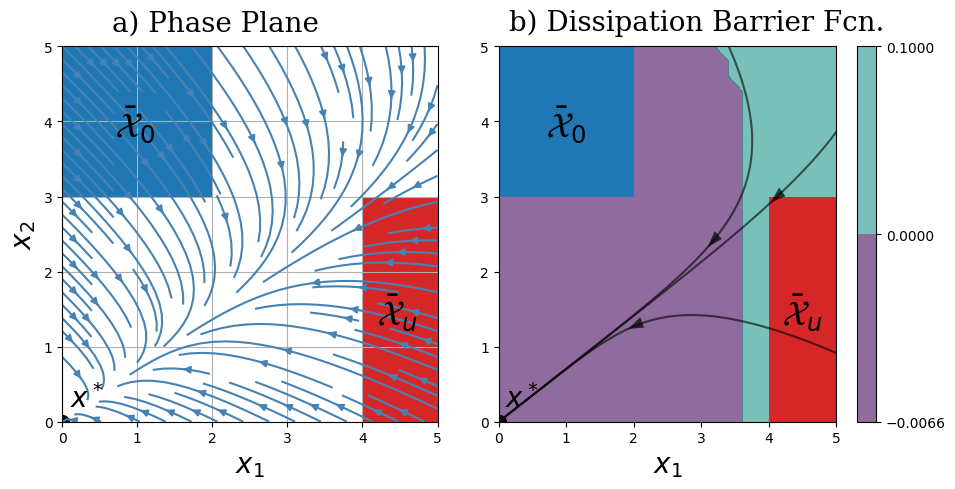

In [137]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5) )
  

cs = ax2.contourf(X1,X2,BXT,3,levels=np.array([np.min(BXT),0.00, np.max(BXT)]),alpha=0.6)
# Create a Rectangle patch
XU = patches.Rectangle((xUlb[0], xUlb[1]), xUub[0]-xUlb[0], xUub[1]-xUlb[1], linewidth=2, edgecolor='None', facecolor='tab:red', alpha = 1)
XU2 = patches.Rectangle((xUlb2[0], xUlb2[1]), xUub2[0]-xUlb2[0], xUub2[1]-xUlb2[1], linewidth=2, edgecolor='None', facecolor='tab:red', alpha = 1)
X0 = patches.Rectangle((x0lb[0], x0lb[1]), x0ub[0]-x0lb[0], x0ub[1]-x0lb[1], linewidth=2, edgecolor='None', facecolor='tab:blue')

#plt.annotate('',xy=(2, 4),xytext=(3, 3.5),arrowprops=dict(facecolor='black', shrink=0.05))
ax2.annotate('$\\bar{\\mathcal{X}}_0$',fontsize = 25, color = 'k',xy = ((x0ub[0]+x0lb[0])/2-0.3, (x0ub[1]+x0lb[1])/2-0.2))#math.degrees(math.atan(x0[0]/x0[1])))
ax2.annotate('$\\bar{\\mathcal{X}}_u$',fontsize = 25, color = 'k',xy = ((xUub[0]+xUlb[0])/2-0.3, (xUub[1]+xUlb[1])/2-0.2))#math.degrees(math.atan(x0[0]/x0[1])))
ax2.annotate('$x^*$',fontsize = 20, color = 'k',xy = np.array([0.1,0.2]))
ax2.plot(*np.array([0,0]),'o', color='black', markersize = 10)


ax2.text(
        0.0, 1.0, 'b) Dissipation Barrier Fcn.', transform=(
            ax2.transAxes + transforms.ScaledTranslation(+0.1,+0.1, fig.dpi_scale_trans)),
        fontsize = 20, va='bottom', fontfamily='serif')


    

# Add the patch to the Axes
ax2.add_patch(XU)
ax2.add_patch(XU2)
ax2.add_patch(X0)
fig.colorbar(cs)


for k in range(NSol):
    ax2.plot(trajectory[k,:,0],trajectory[k,:,1],color = 'black',alpha = 0.6)
    ll1 = trajectory[k,100,:]
    ll2 = trajectory[k,101,:]
    ax2.arrow(ll1[0],ll1[1], ll2[0] - ll1[0],ll2[1] - ll1[1], shape='full', lw=0, length_includes_head=True, head_width=0.15,color = 'black',alpha = 0.7)
    ll1 = trajectory[k,1,:]
    ll2 = trajectory[k,1+1,:]
    ax2.arrow(ll1[0],ll1[1], ll2[0] - ll1[0],ll2[1] - ll1[1], shape='full', lw=0, length_includes_head=True, head_width=0.15,color = 'black',alpha = 0.7)

# Add labels, title, and legend
ax2.set_xlabel('$x_1$',fontsize=20)

ax2.axis([0.0, 5.0, 0.0, 5.0])


#######################################################################
XX, YY = np.meshgrid(np.linspace(0.0, 5.0, 10), np.linspace(0.0, 5.0,10))
u, v = np.zeros_like(XX), np.zeros_like(YY)
NI, NJ = XX.shape

for i in range(NI):
    for j in range(NJ):
        xx, yx = XX[i, j], YY[i, j]
        #r, theta = (x**2 + y**2)**0.5, np.arctan2(y, x)
        fp = fdt([xx,yx])
        u[i,j] = fp[0]-xx
        v[i,j] = fp[1]-yx


# Create a Rectangle patch
XUpp = patches.Rectangle((xUlb[0], xUlb[1]), xUub[0]-xUlb[0], xUub[1]-xUlb[1], linewidth=2, edgecolor='None', facecolor='tab:red')
XU2pp = patches.Rectangle((xUlb2[0], xUlb2[1]), xUub2[0]-xUlb2[0], xUub2[1]-xUlb2[1], linewidth=2, edgecolor='None', facecolor='tab:red')
X0pp = patches.Rectangle((x0lb[0], x0lb[1]), x0ub[0]-x0lb[0], x0ub[1]-x0lb[1], linewidth=2, edgecolor='None', facecolor='tab:blue')
ax1.add_patch(XUpp)
ax1.add_patch(XU2pp)
ax1.add_patch(X0pp)


#plt.annotate('',xy=(2, 4),xytext=(3, 3.5),arrowprops=dict(facecolor='black', shrink=0.05))
ax1.annotate('$\\bar{\\mathcal{X}}_0$',fontsize = 25, color = 'k',xy = ((x0ub[0]+x0lb[0])/2-0.3, (x0ub[1]+x0lb[1])/2-0.2))#math.degrees(math.atan(x0[0]/x0[1])))
ax1.annotate('$\\bar{\\mathcal{X}}_u$',fontsize = 25, color = 'k',xy = ((xUub[0]+xUlb[0])/2-0.3, (xUub[1]+xUlb[1])/2-0.2))#math.degrees(math.atan(x0[0]/x0[1])))
ax1.annotate('$x^*$',fontsize = 20, color = 'k',xy = np.array([0.1,0.2]))
ax1.plot(*np.array([0,0]),'o', color='black', markersize = 10)

strm = ax1.streamplot(XX, YY, u, v,color = 'steelblue')


ax1.text(
        0.0, 1.0, 'a) Phase Plane', transform=(
            ax1.transAxes + transforms.ScaledTranslation(+0.5, +0.1, fig.dpi_scale_trans)),
        fontsize = 20, va='bottom', fontfamily='serif')

ax1.axis('square')
#ax1.set_title("Phase Plane",fontsize=20)
ax1.set_xlabel('$x_1$',fontsize=20)
ax1.set_ylabel('$x_2$',fontsize=20)
ax1.grid(True)
ax1.axis([0, 5, 0, 5])

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()



fig.savefig('ex_linear_T2d.pdf', format='pdf')